In [1]:
# coding: utf-8
#やろうとしてること
#1: 特徴量を生成する前に特定のデータについて確認し、方針を決める。
#2: 各項目から特徴量を生成し、年齢以外の欠損値を埋める。Ticketは今回は除外する。不要な特徴量は適宜削減する。
#3: アルゴリズムはランダムフォレストを使う。グリッドサーチを使い最良のパラメータを取得する。
#4: 一番良かった結果のパラメータを使って提出用データを作る．

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
test_result = pd.read_csv("./gender_submission.csv")

#データ加工のため、trainとtestと回答を全部合わせて1300余件のデータセットを作る。（後で分割する）

test = pd.merge(test_data, test_result, how="outer", on="PassengerId")
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1233,NaN,NaN,S,69.55,"Sage, Mr. John George",9,1234,3,male,1,0,CA. 2343
1256,NaN,NaN,S,69.55,"Sage, Mrs. John (Annie Bullen)",9,1257,3,female,1,1,CA. 2343


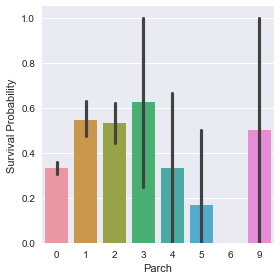

In [2]:
#1: 特徴量を生成する前に特定のデータについて確認し、方針を決める。

#Parchについて確認
g = sns.factorplot(y="Survived", x="Parch", data=df, kind="bar")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#1,2,3が生存率が高い。9は異常値かも知れないので確認の必要あり。
df[df["Parch"]==9].head()

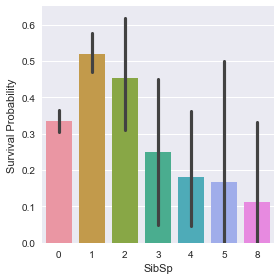

In [3]:
#SibSpについて確認
g = sns.factorplot(y="Survived", x="SibSp", data=df, kind="bar")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#1,2が生存率が高い。増える程生存率は下がる。

In [4]:
#2: 各項目から特徴量を生成し、年齢以外の欠損値を埋める。Ticketは今回は除外する。不要な特徴量は適宜削減する。

df = pd.get_dummies(df, columns=["Embarked"], prefix="Em")
df = pd.get_dummies(df, columns=["Pclass"], prefix="Pc")
df = pd.get_dummies(df, columns=["Sex"])
df.drop(labels=["Ticket","Sex_male"], axis=1, inplace=True)
df.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Sex_female
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0,0,0,1,0,0,1,0
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,0,0,1,0,0,1
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1,0,0,1,0,0,1,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,0,0,1,1,0,0,1
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,5,0,0,0,0,1,0,0,1,0


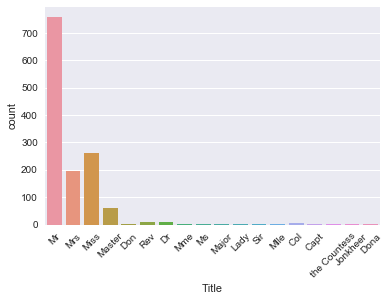

In [5]:
#名前から称号を検出し、特徴量に変換する
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
#df["Title"].value_counts() #MlleがMileに見えてスペリングミスしたので確認用
g = sns.countplot(x="Title", data=df)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [6]:
df["Title"] = df["Title"].replace(['the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms":1, "Mme":1, "Mlle":1, "Lady":1, "Mrs":2, "Mr":3, "Rare":4})
df["Title"] = df["Title"].astype('int')
df.drop(labels=["Name"], axis=1, inplace=True)
df.head()

,Age,Cabin,Fare,Parch,PassengerId,SibSp,Survived,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Sex_female,Title
0,22.0,NaN,7.2500,0,1,1,0,0,0,1,0,0,1,0,3
1,38.0,C85,71.2833,0,2,1,1,1,0,0,1,0,0,1,2
2,26.0,NaN,7.9250,0,3,0,1,0,0,1,0,0,1,1,1
3,35.0,C123,53.1000,0,4,1,1,0,0,1,1,0,0,1,2
4,35.0,NaN,8.0500,0,5,0,0,0,0,1,0,0,1,0,3


,Age,Cabin,Fare,PassengerId,Survived,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Sex_female,Title,F_single,F_small,F_middle,F_large
0,22.0,NaN,7.2500,1,0,0,0,1,0,0,1,0,3,0,1,0,0
1,38.0,C85,71.2833,2,1,1,0,0,1,0,0,1,2,0,1,0,0
2,26.0,NaN,7.9250,3,1,0,0,1,0,0,1,1,1,1,0,0,0
3,35.0,C123,53.1000,4,1,0,0,1,1,0,0,1,2,0,1,0,0
4,35.0,NaN,8.0500,5,0,0,0,1,0,0,1,0,3,1,0,0,0


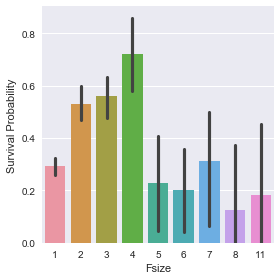

In [7]:
#ParchとSibSpを合計した場合の分布はどうなる？（末尾の+1は乗船者本人を足す）
df["Fsize"] = df["Parch"] + df["SibSp"] + 1
g = sns.factorplot(y="Survived", x="Fsize", data=df, kind="bar")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#2,3,4が抜きん出て高い数値。1人の"単独者”、2-3人の"小家族"、4人の"中家族"、それ以上の"大家族"の4グループに分けたい
df["F_single"] = df["Fsize"].map(lambda s: 1 if s == 1 else 0)
df["F_small"] = df["Fsize"].map(lambda s: 1 if 2 <= s <= 3 else 0)
df["F_middle"] = df["Fsize"].map(lambda s: 1 if s == 4 else 0)
df["F_large"] = df["Fsize"].map(lambda s: 1 if 5 <= s else 0)

df.drop(labels=["Parch","SibSp","Fsize"], axis=1, inplace=True)

df.head()

,Age,Cabin,PassengerId,Survived,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Sex_female,Title,F_single,F_small,F_middle,F_large,Fare_class
0,22.0,NaN,1,0,0,0,1,0,0,1,0,3,0,1,0,0,0
1,38.0,C85,2,1,1,0,0,1,0,0,1,2,0,1,0,0,7
2,26.0,NaN,3,1,0,0,1,0,0,1,1,1,1,0,0,0,0
3,35.0,C123,4,1,0,0,1,1,0,0,1,2,0,1,0,0,5
4,35.0,NaN,5,0,0,0,1,0,0,1,0,3,1,0,0,0,0


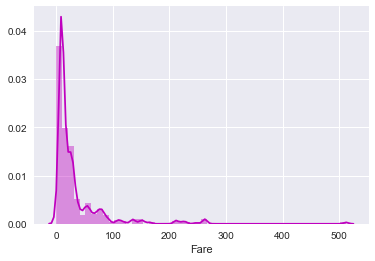

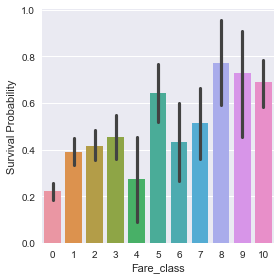

In [8]:
#Fare 乗船費用と生存率の関連性を確認する

#Fareの欠損値に該当した人物のデータを確認。「３等船室、男性、60.5歳」という条件から死亡と推定し0埋めする
df["Fare"] = df["Fare"].fillna(0)

g = sns.distplot(df["Fare"], color="m", label="Skewness : %.2f"%(df["Fare"].skew()))

#乗船費用別に分けるメソッド
def fare_identifier(data):
    
    fare_result = []
    for row in range(0, len(data)):
        df = data.iloc[row]
        if df.Fare < 10:
            fare_result.append(0)
        elif 10 <= df.Fare < 20:
            fare_result.append(1)
        elif 20 <= df.Fare < 30:
            fare_result.append(2)
        elif 30 <= df.Fare < 40:
            fare_result.append(3)
        elif 40 <= df.Fare < 50:
            fare_result.append(4)
        elif 50 <= df.Fare < 60:
            fare_result.append(5)
        elif 60 <= df.Fare < 70:
            fare_result.append(6)
        elif 70 <= df.Fare < 80:
            fare_result.append(7)
        elif 80 <= df.Fare < 90:
            fare_result.append(8)
        elif 90 <= df.Fare < 100:
            fare_result.append(9)
        elif 100 <= df.Fare:
            fare_result.append(10)
                
    ar = pd.DataFrame(fare_result, columns={'Fare_class'})
    data = pd.concat((data, ar), axis=1)
   
    return data

df = fare_identifier(df)

#上のメソッドを使って乗船費用別に分ける
g = sns.factorplot(y="Survived", x="Fare_class", data=df, kind="bar")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")
df.drop(labels=["Fare"], axis=1, inplace=True)

#乗船費用別の生存率の結果、3グループに分ける。5,8-10を"2"、1,2,3,6,7を"1"、0,4を"0"
#df["Fare_class"] = df["Fare_class"].astype('str')
#df["Fare_Suv"] = df["Fare_class"].map({"0":0, "1":1, "2":1, "3":1, "4":0, "5":2, "6":1, "7":1, "8":2, "9":2, "10":2})
#df["Fare_Suv"] = df["Fare_Suv"].astype('int')
#df.drop(labels=["Fare","Fare_class"], axis=1, inplace=True)

df.head()

,Age,PassengerId,Survived,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Sex_female,...,Fare_class,Cab_A,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_X
0,22.0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,2,1,1,0,0,1,0,0,1,...,7,0,0,1,0,0,0,0,0,0
2,26.0,3,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,35.0,4,1,0,0,1,1,0,0,1,...,5,0,0,1,0,0,0,0,0,0
4,35.0,5,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


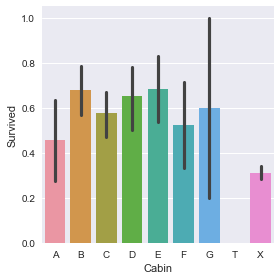

In [9]:
#船室はCabinの頭文字から取り、Nanの場合はXとする
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df["Cabin"]])
g = sns.factorplot(y="Survived", x="Cabin", data=df, kind="bar", order=["A","B","C","D","E","F","G","T","X"])

#生存率の低いXを0、それ以外を1として特徴量を作成する場合のコード（スコアが0.015程下がったので使わない。参考コード）
#df["Cabin"] = df["Cabin"].map({"A":1, "B":1, "C":1, "D":1, "E":1, "F":1, "G":1, "T":1, "X":0})
#df["Cabin"] = df["Cabin"].astype("int")

df = pd.get_dummies(df, columns=["Cabin"], prefix="Cab")
#df.drop(labels="Cab_1", axis=1, inplace=True)
df.head()

In [10]:
#称号ごとの年齢の平均値をAgeの欠損値に宛がうメソッド
def age_identifier(data, age_class):
    
    age_result = []
    for row in range(0, len(data)):
        df = data.iloc[row]
        if 1 > df.Age >= 0: 
            age_result.append(1)
        elif df.Age >= 1:
            age_result.append(df.Age)
        else:
            if df.Title == 1:
                age_result.append(age_class[1])
            elif df.Title == 2:
                age_result.append(age_class[2])
            elif df.Title == 3:
                age_result.append(age_class[3])
            elif df.Title == 4:
                age_result.append(age_class[4])
            elif df.Title == 0:
                age_result.append(age_class[0])
                
    data = data.drop((["Age"]), axis=1)
    ar = pd.DataFrame(age_result, columns={'Age'})
    data = pd.concat((data, ar), axis=1)
   
    return data

In [11]:
#年齢の欠損はTitle（Mrなど）の平均年齢で埋める
age_means = df.groupby(["Title"]).agg(['mean']).astype(int)
age_means = list(age_means.values.flatten())
df = age_identifier(df, age_means)

df.head()

,PassengerId,Survived,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Sex_female,Title,...,Cab_A,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_X,Age
0,1,0,0,0,1,0,0,1,0,3,...,0,0,0,0,0,0,0,0,1,22.0
1,2,1,1,0,0,1,0,0,1,2,...,0,0,1,0,0,0,0,0,0,38.0
2,3,1,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,26.0
3,4,1,0,0,1,1,0,0,1,2,...,0,0,1,0,0,0,0,0,0,35.0
4,5,0,0,0,1,0,0,1,0,3,...,0,0,0,0,0,0,0,0,1,35.0


In [12]:
#データセットを再分割して訓練セットとテストセットに戻す。

X_train = pd.DataFrame(df[:len(train)])
X_test = pd.DataFrame(df[len(train):])

Y_train = pd.Series(X_train["Survived"])
X_train.drop(labels=["Survived","PassengerId"], axis=1, inplace=True)

X_test.drop(labels=["Survived","PassengerId"], axis=1, inplace=True)

In [13]:
#3: アルゴリズムはランダムフォレストを使う。グリッドサーチを使い最良のパラメータを取得する。

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [14]:
RFC = RandomForestClassifier()
RF_Param_Grid = {
    "max_depth": [4,8,16,32],
    "min_samples_split": [2,4,8,16],
    "min_samples_leaf": [1,3],
    "bootstrap": [False],
    "n_estimators": [50,100],
    "criterion": ["gini"]
}
kfold = StratifiedKFold(n_splits=10)

g_clf = GridSearchCV(RFC, param_grid=RF_Param_Grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
g_clf.fit(X_train, Y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.8s
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [4, 8, 16, 32], 'min_samples_split': [2, 4, 8, 16], 'min_samples_leaf': [1, 3], 'bootstrap': [False], 'n_estimators': [50, 100], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [15]:
g_clf.best_score_

0.83164983164983164

In [16]:
g_cv_results = pd.DataFrame(g_clf.cv_results_)
g_cv_results.to_csv("./work/cv_results_20171015b.csv")

g_clf.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 16,
 'n_estimators': 100}

In [17]:
#4: 一番良かった結果のパラメータを使って提出用データを作る．

bp = g_clf.best_params_

clf = RandomForestClassifier(
    bootstrap=bp["bootstrap"], 
    criterion=bp["criterion"], 
    max_depth=bp["max_depth"], 
    min_samples_leaf=bp["min_samples_leaf"], 
    min_samples_split=bp["min_samples_split"], 
    n_estimators=bp["n_estimators"]
)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
IDtest = test_data["PassengerId"]
test_Survived = pd.Series(clf.predict(X_test), name="Survived")
results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv("./work/titanic_try_20171015b.csv", index=False)